In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [161]:
img_size = (320, 320)
input_size = 320
# batch_size = 64
batch_size = 96

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**Downloading data**

In [7]:
directory = "/content/drive/MyDrive/projects"
input_dir = os.path.join(directory, "training_real_faces")
input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

print("Number of samples:", len(input_img_paths))

Number of samples: 1081


**Prepearing data**

(600, 600, 3)


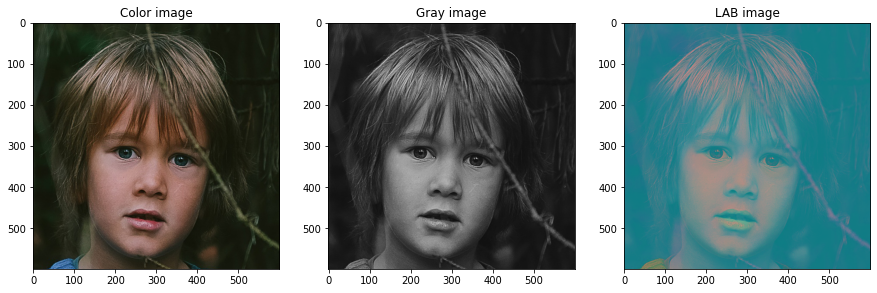

In [8]:
samples = len(input_img_paths)
idx = 29

img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.subplot(131), plt.imshow(img)
plt.title("Color image")
plt.subplot(132), plt.imshow(grey, cmap='gray')
plt.title("Gray image")
plt.subplot(133), plt.imshow(img_lab)
plt.title("LAB image")

print(img.shape)

Text(0.5, 1.0, 'B channel')

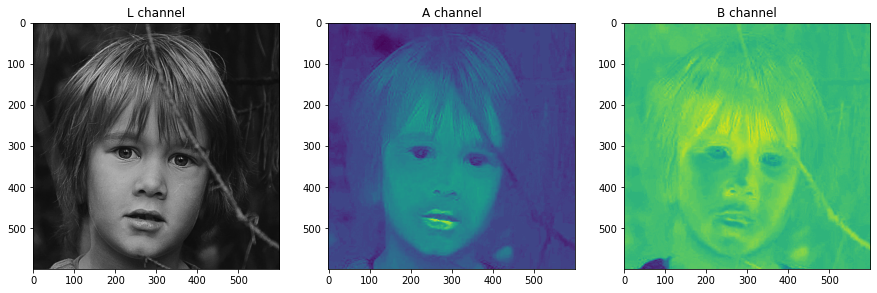

In [9]:
plt.subplot(131), plt.imshow(img_lab[:,:,0], cmap='gray')
plt.title("L channel")
plt.subplot(132), plt.imshow(img_lab[:,:,1])
plt.title("A channel")
plt.subplot(133), plt.imshow(img_lab[:,:,2])
plt.title("B channel")

In [10]:
def ExtractInput(ImagePath):
    X_img=[]
    y_img=[]
    for imageDir in input_img_paths:
        try:
            img = cv2.imread(imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab) #Convert the rgb values to the Lab format
 
            img_lab = img_lab/255.0
            img_lab_rs = cv2.resize(img_lab, (input_size, input_size)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:] # Extracting the ab channel

            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

X, y = ExtractInput(input_img_paths)
X_train,X_val,y_train,y_val = train_test_split(X,y, random_state=seed_value)

In [11]:
# Data generator
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = np.expand_dims(X[i], axis=0)
        y_input = y[i];
        yield (X_input,y_input)

**Simple model**

In [12]:
def get_Alpha_model(input_size):
    inputs = layers.Input(shape=(input_size, input_size, 1))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    return model

A_model = get_Alpha_model(input_size)
A_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 8)       584       
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 32)        9248  

In [13]:
A_model.compile(optimizer='rmsprop', loss='mse')
A_model.fit(GenerateInputs(X_train,y_train), epochs=20, verbose=1, steps_per_epoch=3, validation_data=(X_val, y_val), shuffle=True)
# A_model.fit(x=X, y=Y, batch_size=1, epochs=3)
print(A_model.evaluate(X_val, y_val))

Epoch 1/20
3/3 [==============================] - 11s 1s/step - loss: 0.0026 - val_loss: 0.0024
Epoch 2/20
3/3 [==============================] - 0s 196ms/step - loss: 0.0131 - val_loss: 0.0024
Epoch 3/20
3/3 [==============================] - 0s 194ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/20
3/3 [==============================] - 0s 192ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/20
3/3 [==============================] - 0s 192ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/20
3/3 [==============================] - 0s 192ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 7/20
3/3 [==============================] - 0s 195ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 8/20
3/3 [==============================] - 0s 191ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/20
3/3 [==============================] - 0s 193ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/20
3/3 [==============================] - 0s 195ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/20
3/3 [====

In [14]:
def show_result(idx, model):
    img_rgb = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (input_size, input_size))
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gray = (1.0/255*gray)

    output = model.predict(np.expand_dims(gray, axis=0))

    # gathering image chanels
    new_img = np.zeros((input_size, input_size, 3))
    new_img[:,:,0] = gray
    new_img[:,:,1:] = output
    new_img = 255*new_img
    new_img = new_img.astype(np.uint8)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

    plt.subplot(131), plt.imshow(gray*255, cmap='gray')
    plt.title("Gray image")
    plt.subplot(132), plt.imshow(new_img)
    plt.title("Predicted image") 
    plt.subplot(133), plt.imshow(img_rgb,)
    plt.title("Ground truth") 


1/1 [==============================] - 0s 120ms/step


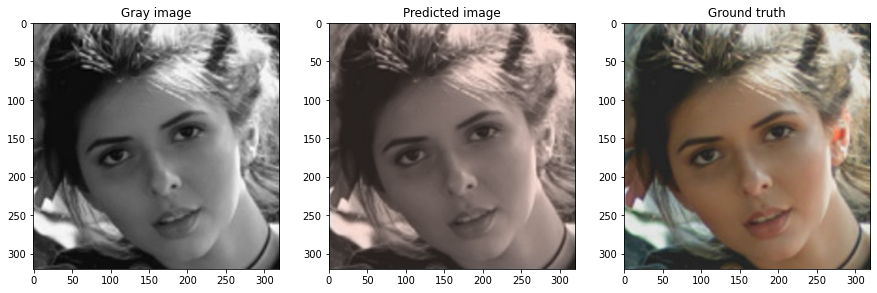

In [15]:
idx = 15
show_result(idx, A_model)

**U-net model**

In [16]:
def plot_history(history, metric):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h[metric], '.-',
                               epochs, h['val_'+metric], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel(metric)
    plt.legend(['Train', 'Validation'])
        
    print('Train     ', h[metric][-1])
    print('Validation', h['val_'+metric][-1])

In [136]:
#Using U-Net architecture 

def get_U_model(input_size):
    inputs = layers.Input(shape=(input_size, input_size, 1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # x = layers.LeakyReLU()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add output layer with sigmoid activation function (result between 0 and 1)
    outputs = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 160, 160, 32  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_105 (Batch  (None, 160, 160, 32  128        ['conv2d_114[0][0]']             
 Normalization)                 )                                                           

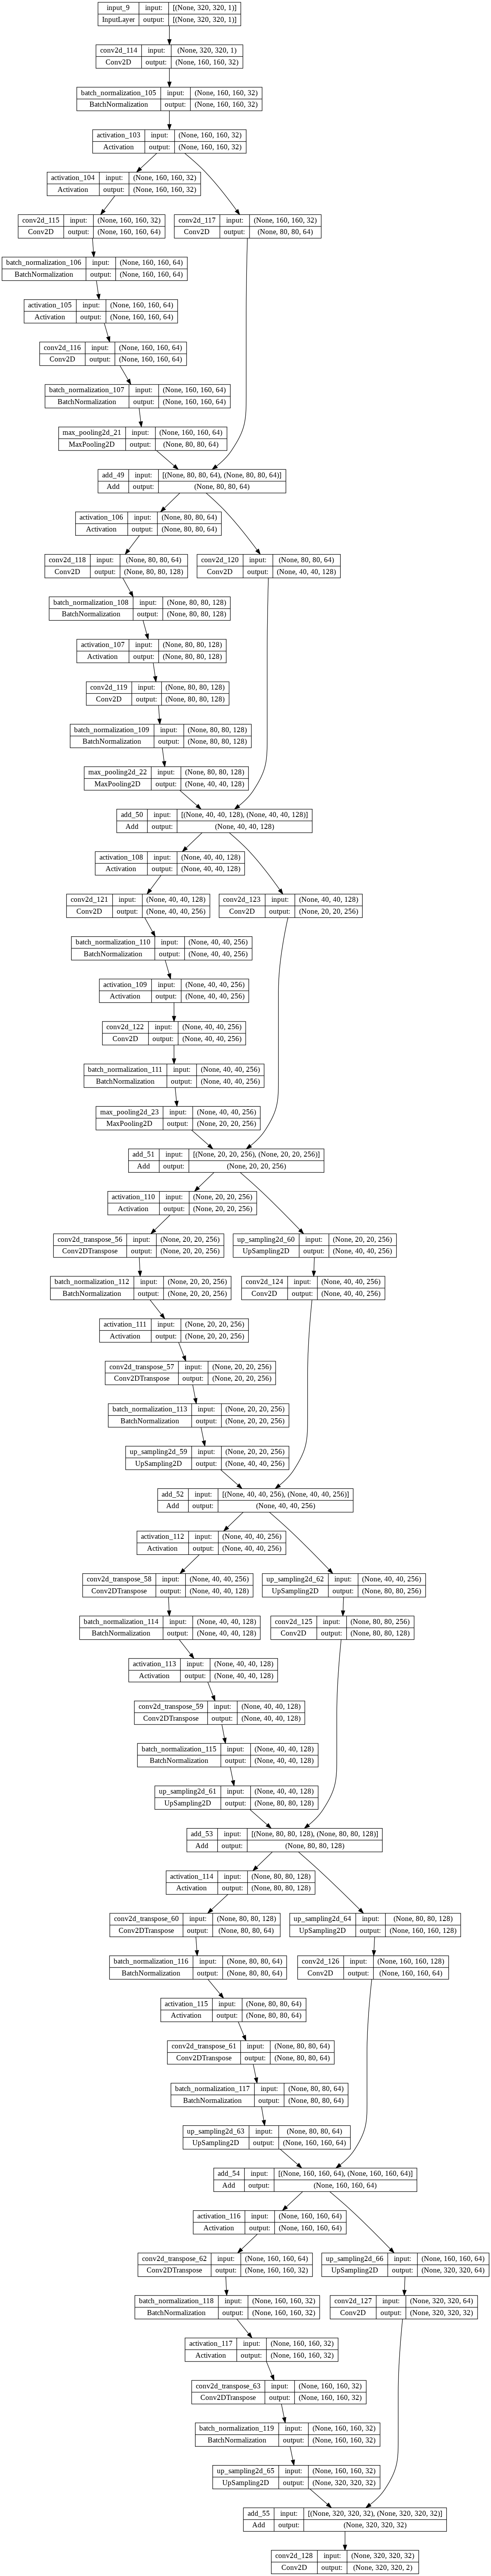

In [191]:
model = get_U_model(input_size)
model.summary()
plot_model(model, show_shapes=True)

In [180]:
# model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
model.compile(optimizer="rmsprop", loss='mse', metrics=["mae"])
callbacks = [tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

epochs = 100
steps_per_epoch = len(y_train) // batch_size
history = model.fit(GenerateInputs(X_train,y_train), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=(X_val, y_val), callbacks=callbacks, shuffle=True)

Epoch 1/100
8/8 [==============================] - 8s 437ms/step - loss: 0.0037 - mae: 0.0428 - val_loss: 0.0037 - val_mae: 0.0461
Epoch 2/100
8/8 [==============================] - 2s 310ms/step - loss: 0.0031 - mae: 0.0391 - val_loss: 0.0026 - val_mae: 0.0390
Epoch 3/100
8/8 [==============================] - 2s 311ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0024 - val_mae: 0.0361
Epoch 4/100
8/8 [==============================] - 2s 312ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0022 - val_mae: 0.0339
Epoch 5/100
8/8 [==============================] - 2s 279ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0025 - val_mae: 0.0362
Epoch 6/100
8/8 [==============================] - 2s 282ms/step - loss: 0.0021 - mae: 0.0343 - val_loss: 0.0024 - val_mae: 0.0364
Epoch 7/100
8/8 [==============================] - 2s 282ms/step - loss: 0.0025 - mae: 0.0372 - val_loss: 0.0032 - val_mae: 0.0391
Epoch 8/100
8/8 [==============================] - 2s 283ms/step - loss: 0.0016 - m

In [181]:
print(model.evaluate(X_val, y_val))

9/9 [==============================] - 2s 198ms/step - loss: 0.0022 - mae: 0.0336
[0.0021923906169831753, 0.03362631797790527]


Train      0.03540999814867973
Validation 0.03362631797790527


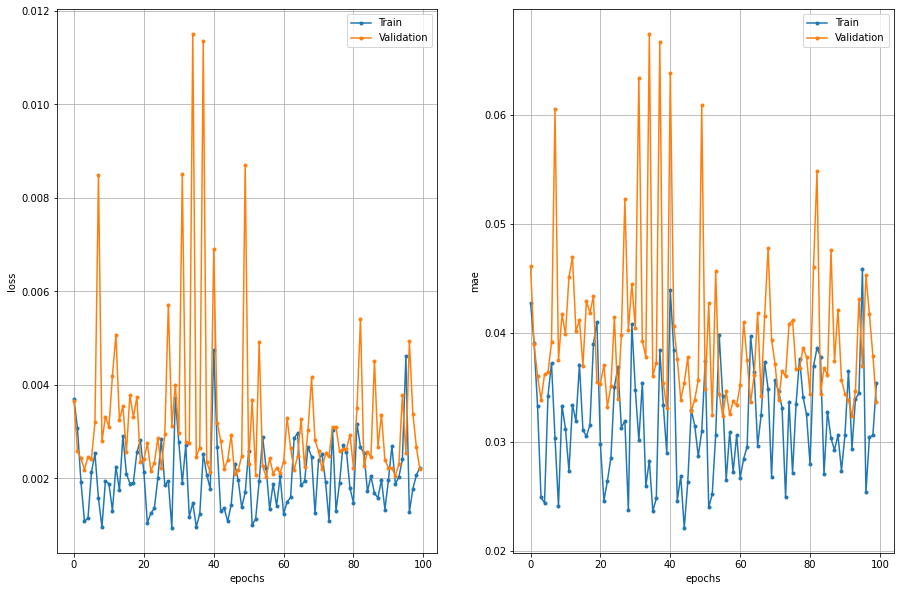

In [182]:
plot_history(history, 'mae')

1/1 [==============================] - 0s 18ms/step


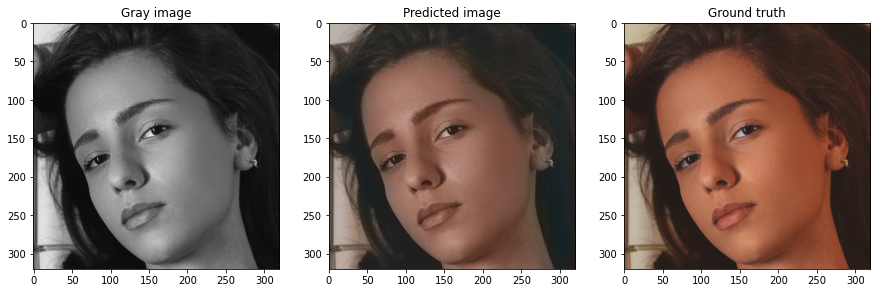

In [186]:
# idx = 324
idx = 25
show_result(idx, model)

In [187]:
X_val.shape

(271, 320, 320)

1/1 [==============================] - 0s 19ms/step


(-0.5, 319.5, 319.5, -0.5)

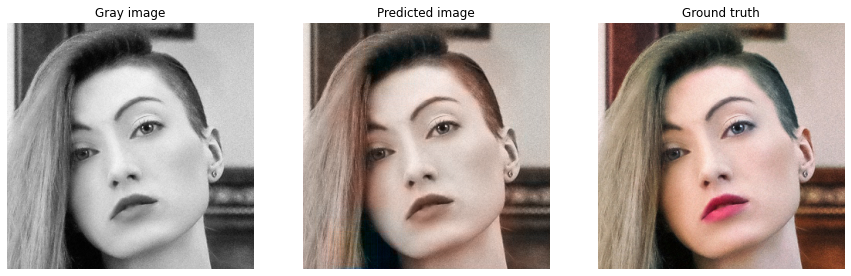

In [190]:
idx = np.random.randint(0, len(X_val))

gray = X_val[idx]

output = model.predict(np.expand_dims(gray, axis=0))

# gathering image chanels
new_img = np.zeros((input_size, input_size, 3))
new_img[:,:,0] = gray
new_img[:,:,1:] = output
new_img = 255*new_img
new_img = new_img.astype(np.uint8)
new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

#lab to rgb
lab_img = np.zeros((input_size, input_size, 3))
lab_img[:,:,0] = gray
lab_img[:,:,1:] = y_val[idx]
lab_img = 255*lab_img
lab_img = lab_img.astype(np.uint8)
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_Lab2RGB)


plt.subplot(131), plt.imshow(gray*255, cmap='gray')
plt.title("Gray image")
plt.axis('off')
plt.subplot(132), plt.imshow(new_img)
plt.title("Predicted image") 
plt.axis('off')
plt.subplot(133), plt.imshow(rgb_img)
plt.title("Ground truth")
plt.axis('off')